In [7]:
from utils import*
import numpy as np
import pandas as pd
import copy
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from cubist import Cubist
import joblib
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import itertools
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [8]:
# Output data path 
file_path = "./data/Wet_chemistry.csv"
output = preprocess_data(file_path)
output.head() 

,Lab_ID,ID,pH,CaCO3,Nt,Ct,Corg,Sand,Silt,Clay,2Micron,MWD
0,41612,B197 q16,7.39,40.04,0.10,6.12,1.31,13.91,53.5,32.2,36.5,0.0992
2,41615,B199 q11,7.34,41.22,0.08,5.38,0.43,7.64,45.3,47.2,43.0,0.0529
3,41616,B201 q3,7.17,31.06,0.10,4.38,0.65,8.65,47.1,43.9,40.3,0.0636
4,41618,B201 q5,7.22,34.1,0.09,4.51,0.41,10.84,49.5,39.9,41.6,0.1405
5,41625,B209 q4,7.35,29.05,0.12,4.54,1.05,31.01,46.8,21.6,31.1,0.2016


In [9]:
# Assuming you have a CSV file named 'data.csv' and the last 9 columns are your responses
df = pd.read_csv("./data/Full_spectra_SG 2.11.csv")
# df = pd.read_csv("./data/Full_spectra_raw.csv")
# df = pd.read_csv("./data/Full_spectra_moving averages 11.csv")
# df = pd.read_csv("./data/Full_spectra_SNV-SG.csv")

# EXP_NAME = 'raw'
# EXP_NAME = 'moving_ave_11'
EXP_NAME = 'SG_2_11'
# EXP_NAME = 'SNV-SG'

df.rename( columns={'Unnamed: 0':'Lab_ID'}, inplace=True )
df.head()

,Lab_ID,SG.2.11.4475,SG.2.11.4471,SG.2.11.4467,SG.2.11.4463,SG.2.11.4459,SG.2.11.4455,SG.2.11.4451,SG.2.11.4447,SG.2.11.4443,...,SG.2.11.555,SG.2.11.551,SG.2.11.547,SG.2.11.543,SG.2.11.539,SG.2.11.535,SG.2.11.531,SG.2.11.527,SG.2.11.523,SG.2.11.519
0,41612,-0.000054,-0.000049,-0.000044,-0.000040,-0.000038,-3.618202e-05,-0.000036,-0.000037,-0.000039,...,0.018555,0.019592,0.020251,0.020553,0.020383,0.019501,0.017485,0.014233,0.010149,0.005962
1,41614,-0.000015,-0.000013,-0.000009,-0.000004,-0.000001,4.041832e-07,0.000003,0.000005,0.000006,...,0.011636,0.012881,0.013714,0.014147,0.014161,0.013630,0.012313,0.010169,0.007497,0.004804
2,41615,-0.000069,-0.000064,-0.000059,-0.000052,-0.000046,-4.355206e-05,-0.000042,-0.000043,-0.000043,...,0.020855,0.022256,0.023136,0.023585,0.023526,0.022666,0.020563,0.017048,0.012470,0.007726
3,41616,-0.000041,-0.000035,-0.000029,-0.000023,-0.000020,-1.894998e-05,-0.000018,-0.000019,-0.000021,...,0.021405,0.022299,0.022750,0.022852,0.022447,0.021200,0.018627,0.014563,0.009483,0.004331
4,41618,-0.000041,-0.000035,-0.000030,-0.000025,-0.000023,-2.111140e-05,-0.000022,-0.000024,-0.000027,...,0.021212,0.022202,0.022809,0.023059,0.022839,0.021686,0.019117,0.015039,0.009974,0.004844


In [10]:
inputs = pd.merge(output, df, on='Lab_ID', how='left')
X_all = df.iloc[:,1:]
inputs

,Lab_ID,ID,pH,CaCO3,Nt,Ct,Corg,Sand,Silt,Clay,...,SG.2.11.555,SG.2.11.551,SG.2.11.547,SG.2.11.543,SG.2.11.539,SG.2.11.535,SG.2.11.531,SG.2.11.527,SG.2.11.523,SG.2.11.519
0,41612,B197 q16,7.39,40.04,0.10,6.12,1.31,13.91,53.5,32.2,...,0.018555,0.019592,0.020251,0.020553,0.020383,0.019501,0.017485,0.014233,0.010149,0.005962
1,41615,B199 q11,7.34,41.22,0.08,5.38,0.43,7.64,45.3,47.2,...,0.020855,0.022256,0.023136,0.023585,0.023526,0.022666,0.020563,0.017048,0.012470,0.007726
2,41616,B201 q3,7.17,31.06,0.10,4.38,0.65,8.65,47.1,43.9,...,0.021405,0.022299,0.022750,0.022852,0.022447,0.021200,0.018627,0.014563,0.009483,0.004331
3,41618,B201 q5,7.22,34.1,0.09,4.51,0.41,10.84,49.5,39.9,...,0.021212,0.022202,0.022809,0.023059,0.022839,0.021686,0.019117,0.015039,0.009974,0.004844
4,41625,B209 q4,7.35,29.05,0.12,4.54,1.05,31.01,46.8,21.6,...,0.015086,0.016420,0.017501,0.018376,0.018843,0.018560,0.017230,0.014854,0.011870,0.009003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,55869,2023B07_23,7.15,15.46,0.11,2.95,1.10,15.65,30.9,53.3,...,0.020722,0.020928,0.020668,0.019933,0.018611,0.016480,0.013345,0.009349,0.004999,0.000904
102,55871,2023B07_24,7.4,26.57,0.05,3.94,0.75,19.41,50.4,30.2,...,0.015118,0.016776,0.018285,0.019518,0.020289,0.020257,0.019036,0.016579,0.013359,0.010049
103,55873,2023B07_24,7.43,22.93,0.04,3.22,0.46,17.28,52.4,30.1,...,0.014151,0.015483,0.016647,0.017501,0.017931,0.017629,0.016312,0.013974,0.011048,0.008113
104,55874,2023B07_24,7.51,23.61,0.05,3.66,0.83,6.91,65.5,27.7,...,0.014980,0.016680,0.018199,0.019449,0.020236,0.020176,0.018917,0.016467,0.013251,0.009939


In [5]:
# df1 = pd.read_csv(".\\export\\predictions_SNV-SG_Nt.csv")
# df2 = inputs
# # Merging the DataFrames on the 'ID1' column from df1 and 'ID2' column from df2
# merged_df = pd.merge(df1, df2, left_on='True Values', right_on='Nt', how = )
# merged = merged_df[['True Values', 'Predictions', 'Lab_ID']]
# merged.shape

In [18]:
# Inputs are columns from 12 onwards
X_all = inputs.iloc[:, 11:].values

# Outputs are columns from 2 to 11 (zero-indexed, so columns 3 to 11 in one-based indexing)
output_columns = inputs.columns[2:11]
output_columns

Index(['pH', 'CaCO3', 'Nt', 'Ct', 'Corg', 'Sand', 'Silt', 'Clay', '2Micron',
       'MWD'],
      dtype='object')

In [31]:
# Inputs the whole samples with full spectra (take the same as your df file)
full_spectra = pd.read_csv("./data/Full_spectra_SG 2.11.csv")
# dfull_spectra = pd.read_csv("./data/Full_spectra_raw.csv")
# full_spectra = pd.read_csv("./data/Full_spectra_moving averages 11.csv")
# full_spectra = pd.read_csv("./data/Full_spectra_SNV-SG.csv")

# EXP_NAME = 'raw'
# EXP_NAME = 'moving_ave_11'
EXP_NAME = 'SG_2_11'
# EXP_NAME = 'SNV-SG'

full_spectra.rename( columns={'Unnamed: 0':'Lab_ID'}, inplace=True )
df_predict = full_spectra.iloc[:, 1:].values
full_spectra.head()

,Lab_ID,SG.2.11.4475,SG.2.11.4471,SG.2.11.4467,SG.2.11.4463,SG.2.11.4459,SG.2.11.4455,SG.2.11.4451,SG.2.11.4447,SG.2.11.4443,...,SG.2.11.555,SG.2.11.551,SG.2.11.547,SG.2.11.543,SG.2.11.539,SG.2.11.535,SG.2.11.531,SG.2.11.527,SG.2.11.523,SG.2.11.519
0,41612,-0.000054,-0.000049,-0.000044,-0.000040,-0.000038,-3.618202e-05,-0.000036,-0.000037,-0.000039,...,0.018555,0.019592,0.020251,0.020553,0.020383,0.019501,0.017485,0.014233,0.010149,0.005962
1,41614,-0.000015,-0.000013,-0.000009,-0.000004,-0.000001,4.041832e-07,0.000003,0.000005,0.000006,...,0.011636,0.012881,0.013714,0.014147,0.014161,0.013630,0.012313,0.010169,0.007497,0.004804
2,41615,-0.000069,-0.000064,-0.000059,-0.000052,-0.000046,-4.355206e-05,-0.000042,-0.000043,-0.000043,...,0.020855,0.022256,0.023136,0.023585,0.023526,0.022666,0.020563,0.017048,0.012470,0.007726
3,41616,-0.000041,-0.000035,-0.000029,-0.000023,-0.000020,-1.894998e-05,-0.000018,-0.000019,-0.000021,...,0.021405,0.022299,0.022750,0.022852,0.022447,0.021200,0.018627,0.014563,0.009483,0.004331
4,41618,-0.000041,-0.000035,-0.000030,-0.000025,-0.000023,-2.111140e-05,-0.000022,-0.000024,-0.000027,...,0.021212,0.022202,0.022809,0.023059,0.022839,0.021686,0.019117,0.015039,0.009974,0.004844


In [7]:
# # Set random seed for reproducibility
# np.random.seed(42)

# # Initialize results dictionary
# results = {}

# # Define number of splits for cross-validation
# n_splits = 5


# param_grid = {
#     'n_rules': [20, 30, 40],
#     'n_committees': [5, 10, 15]
# }

# # Outer loop: Stratified k-fold cross-validation
# for column in output_columns:
#     y = inputs[column].values

#     y_binned = create_stratified_bins(y)

#     # Debug: Print the shapes of X and y_binned
#     # print(f"Processing target column: {column}")
#     # print(f"Shape of X_all: {X_all.shape}")
#     # print(f"Shape of y: {y.shape}")
#     # print(f"Shape of y_binned: {y_binned.shape}")

#     outer_skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
#     all_true_values = []
#     all_predictions = []
    
#     for train_index, test_index in outer_skf.split(X_all, y_binned):
#         X_train, X_test = X_all[train_index], X_all[test_index]
#         y_train, y_test = y[train_index], y[test_index]

#         # Inner loop: Stratified k-fold cross-validation for grid search
#         inner_skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
#         best_params = None
#         best_score = float('inf')
        
#         for params in [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]:
#             inner_scores = []
#             for inner_train_index, inner_val_index in inner_skf.split(X_train, y_binned[train_index]):
#                 X_inner_train, X_val = X_train[inner_train_index], X_train[inner_val_index]
#                 y_inner_train, y_val = y_train[inner_train_index], y_train[inner_val_index]

#                 model = Cubist(n_committees=params['n_committees'], n_rules=params['n_rules'])
#                 model.fit(X_inner_train, y_inner_train)
#                 predictions = model.predict(X_val)
                
#                 mse = mean_squared_error(y_val, predictions)
#                 inner_scores.append(mse)
            
#             mean_inner_score = np.mean(inner_scores)
#             if mean_inner_score < best_score:
#                 best_score = mean_inner_score
#                 best_params = params
        
#         # print(f'Column: {column}, Best parameters are: {best_params}')
#         # print(f'Column: {column}, Best score (mae) is: {best_score}')
        

#         # Train final model with the best hyperparameters
#         final_model = Cubist(n_committees=best_params['n_committees'], n_rules=best_params['n_rules'])
#         final_model.fit(X_train, y_train)
#         final_predictions = final_model.predict(X_test)

#         # Save predictions and true values
#         all_predictions.extend(final_predictions)
#         all_true_values.extend(y_test)
    
#     # Calculate evaluation metrics
#     all_predictions = np.array(all_predictions)
#     all_true_values = np.array(all_true_values)

#     mse = mean_squared_error(all_true_values, all_predictions)
#     mae = mean_absolute_error(all_true_values, all_predictions)
#     r2 = r2_score(all_true_values, all_predictions)
#     rmse = mean_squared_error(all_true_values, all_predictions, squared=False)
#     ccc = concordance_cc(all_true_values, all_predictions)

#     # Calculate the first and third quantiles
#     Q1 = np.percentile(all_predictions, 25)
#     Q3 = np.percentile(all_predictions, 75)

#     rpiq = (Q3-Q1) / rmse

    
#     results[column] = {
#         'mse': mse,
#         'mae': mae,
#         'r2': r2,
#         'rmse': rmse,
#         'ccc': ccc,
#         'RPIQ': rpiq,
#         'predictions': all_predictions,
#         'true_values': all_true_values
#     }

#     # Save predictions and true values to a file
#     df = pd.DataFrame({
#         'True Values': all_true_values,
#         'Predictions': all_predictions
#     })
#     df.to_csv(f'predictions_{EXP_NAME}_{column}.csv', index=False)

#     # Save metrics to a file
#     metrics_df = pd.DataFrame({
#         'Metric': ['MSE', 'MAE', 'R2', 'RMSE', 'CCC' ,'RPIQ'],
#         'Value': [mse, mae, r2, rmse, ccc, rpiq]
#     })
#     metrics_df.to_csv(f'metrics_{EXP_NAME}_{column}.csv', index=False)

#     # Plot true vs predicted values
#     plot_true_vs_predicted(all_true_values, all_predictions, title=f'True vs Predicted for {column}')

#     # Display the results
#     for column, performance in results.items(): 
#      print(f'Column: {column}, MSE: {performance["mse"]}')
#      print(f'Column: {column}, MAE: {performance["mae"]}')
#      print(f'Column: {column}, R2: {performance["r2"]}')
#      print(f'Column: {column}, RMSE: {performance["rmse"]}')
#      print(f'Column: {column}, CCC: {performance["ccc"]}')
#      print(f'Column: {column}, RPIQ: {performance["RPIQ"]}')

#     results = {}

Processing target column: pH


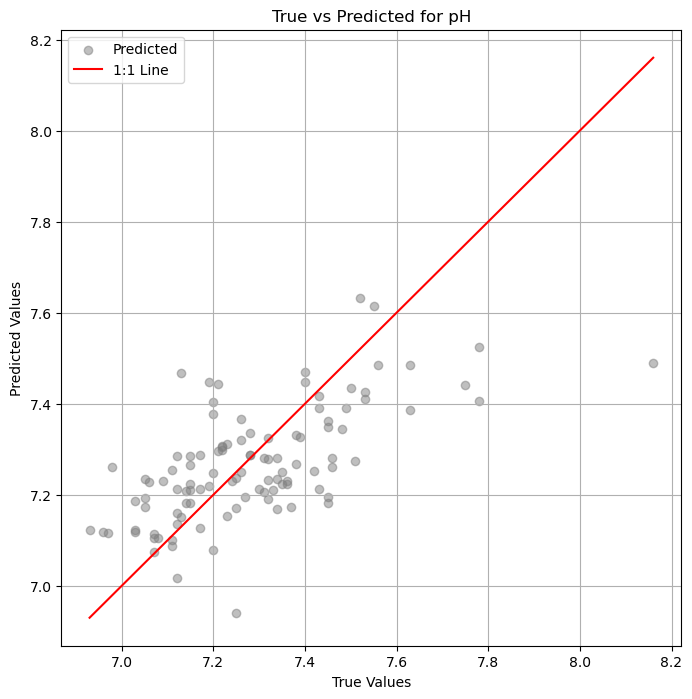

Column: pH, MSE: 0.02315277813708945
Column: pH, MAE: 0.11772692032580105
Column: pH, R2: 0.40812960956145383
Column: pH, RMSE: 0.15216036979808326
Column: pH, CCC: 0.58143318238187
Column: pH, RPIQ: 0.9712109831597551
Processing target column: CaCO3


KeyboardInterrupt: 

In [33]:

# Set random seed for reproducibility
np.random.seed(42)

# Initialize results dictionary
results = {}

# Define number of splits for cross-validation
n_splits = 5

param_grid = {
    'n_rules': [20, 30, 40],
    'n_committees': [5, 10, 15]
}

# Outer loop: Stratified k-fold cross-validation
for column in output_columns:
    y = inputs[column].values
    y_binned = create_stratified_bins(y)

    print(f"Processing target column: {column}")

    outer_skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    all_true_values = []
    all_predictions = []
    all_indices = []  # To store the indices of the 
     samples

    for train_index, test_index in outer_skf.split(X_all, y_binned):
        X_train, X_test = X_all[train_index], X_all[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Inner loop: Stratified k-fold cross-validation for grid search
        inner_skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        best_params = None
        best_score = float('inf')
        
        for params in [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]:
            inner_scores = []
            for inner_train_index, inner_val_index in inner_skf.split(X_train, y_binned[train_index]):
                X_inner_train, X_val = X_train[inner_train_index], X_train[inner_val_index]
                y_inner_train, y_val = y_train[inner_train_index], y_train[inner_val_index]

                model = Cubist(n_committees=params['n_committees'], n_rules=params['n_rules'])
                model.fit(X_inner_train, y_inner_train)
                predictions = model.predict(X_val)
                
                mse = mean_squared_error(y_val, predictions)
                inner_scores.append(mse)
            
            mean_inner_score = np.mean(inner_scores)
            if mean_inner_score < best_score:
                best_score = mean_inner_score
                best_params = params

        # Train final model with the best hyperparameters
        final_model = Cubist(n_committees=best_params['n_committees'], n_rules=best_params['n_rules'])
        final_model.fit(X_train, y_train)
        final_predictions = final_model.predict(X_test)

        # Save predictions, true values, and indices
        all_predictions.extend(final_predictions)
        all_true_values.extend(y_test)
        all_indices.extend(test_index)  # Save the indices of the test samples
    
    # Calculate evaluation metrics
    all_predictions = np.array(all_predictions)
    all_true_values = np.array(all_true_values)

    mse = mean_squared_error(all_true_values, all_predictions)
    mae = mean_absolute_error(all_true_values, all_predictions)
    r2 = r2_score(all_true_values, all_predictions)
    rmse = mean_squared_error(all_true_values, all_predictions, squared=False)
    ccc = concordance_cc(all_true_values, all_predictions)

    # Calculate the first and third quantiles
    Q1 = np.percentile(all_predictions, 25)
    Q3 = np.percentile(all_predictions, 75)
    rpiq = (Q3 - Q1) / rmse

    results[column] = {
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'rmse': rmse,
        'ccc': ccc,
        'RPIQ': rpiq,
        'predictions': all_predictions,
        'true_values': all_true_values
    }

    # Save predictions, true values, and indices to a file
    df = pd.DataFrame({
        'Lab_ID': inputs['Lab_ID'].iloc[all_indices].values,
        'True Values': all_true_values,
        'Predictions': all_predictions
    })
    df.to_csv(f'predictions_{EXP_NAME}_{column}.csv', index=False)

    # Save metrics to a file
    metrics_df = pd.DataFrame({
        'Metric': ['MSE', 'MAE', 'R2', 'RMSE', 'CCC', 'RPIQ'],
        'Value': [mse, mae, r2, rmse, ccc, rpiq]
    })
    metrics_df.to_csv(f'metrics_{EXP_NAME}_{column}.csv', index=False)

    # Predicted the whole spectra to a file
    final_full_predictions = final_model.predict(df_predict)
    df_predictions_final = pd.DataFrame({
        'Lab_ID': full_spectra['Lab_ID'],
        'Predictions': final_full_predictions
    })
    df_predictions_final.to_csv(f'final_full_prediction_{EXP_NAME}_{column}.csv', index=False)

    # Plot true vs predicted values
    plot_true_vs_predicted(all_true_values, all_predictions, title=f'True vs Predicted for {column}')

    # Display the results
    for column, performance in results.items():
        print(f'Column: {column}, MSE: {performance["mse"]}')
        print(f'Column: {column}, MAE: {performance["mae"]}')
        print(f'Column: {column}, R2: {performance["r2"]}')
        print(f'Column: {column}, RMSE: {performance["rmse"]}')
        print(f'Column: {column}, CCC: {performance["ccc"]}')
        print(f'Column: {column}, RPIQ: {performance["RPIQ"]}')

    results = {}
